Next Purchase Date Prediction, 
author: Andrzej Różyc
2018-11-29

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Importing libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta,date
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.cluster import KMeans

from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

Reading dataset

In [0]:
transactions_data = pd.read_csv('/content/drive/My Drive/Datasets/retail_data.csv')
#Convert text invoce date to datetime 
transactions_data['InvoiceDate'] = pd.to_datetime(transactions_data['InvoiceDate'])
#Take only orders from transactions (quantity >= 0 and UnitPrice  >= 0)
orders_data = transactions_data[(transactions_data.Quantity >= 0) & (transactions_data.UnitPrice>=0 )].reset_index(drop=True)

In [0]:
orders_data['Quantity'].describe()

count    531283.000000
mean         10.655299
std         156.830617
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [0]:
orders_data['UnitPrice'].describe()

count    531283.000000
mean          3.898954
std          35.876279
min           0.000000
25%           1.250000
50%           2.080000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

Splitting data (first part will be used as a behavioral data to predict next purchase for a customer and a product)

In [0]:
orders_data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,5504.0,United Kingdom
1,1,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,5504.0,United Kingdom
2,1,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,5504.0,United Kingdom
3,1,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,5504.0,United Kingdom
4,1,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,5504.0,United Kingdom


In [0]:
df_first = orders_data[(orders_data.InvoiceDate < date(2011,10,1))].reset_index(drop=True)
df_next = orders_data[(orders_data.InvoiceDate >= date(2011,10,1))].reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


In [0]:
df_first['InvoiceDate'].describe()

count                  363254
unique                  13749
top       2011-06-29 15:58:00
freq                      705
first     2010-12-01 08:26:00
last      2011-09-30 17:22:00
Name: InvoiceDate, dtype: object

In [0]:
df_next['InvoiceDate'].describe()

count                  168029
unique                   5301
top       2011-10-31 14:41:00
freq                     1114
first     2011-10-02 10:32:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [0]:
df_first['StockCode'].describe()

count     363254
unique      3764
top       85123A
freq        1778
Name: StockCode, dtype: object

In [0]:
df_next['StockCode'].describe()

count     168029
unique      3181
top        22086
freq         760
Name: StockCode, dtype: object

In [0]:
df_product = pd.DataFrame(df_first['StockCode'].unique())
df_product.columns = ['StockCode']

Labelling - product

In [0]:
df_next_first_purchase = df_next.groupby('StockCode').InvoiceDate.min().reset_index()

In [0]:
df_next_first_purchase.columns = ['StockCode','MinPurchaseDate']

In [0]:
df_next_first_purchase.head()

,StockCode,MinPurchaseDate
0,10080,2011-10-10 15:39:00
1,10120,2011-10-03 11:34:00
2,10124A,2011-11-06 13:00:00
3,10124G,2011-11-06 13:00:00
4,10125,2011-10-02 13:49:00


In [0]:
df_last_purchase = df_first.groupby('StockCode').InvoiceDate.max().reset_index()

In [0]:
df_last_purchase.columns = ['StockCode','MaxPurchaseDate']

In [0]:
df_purchase_dates = pd.merge(df_last_purchase,df_next_first_purchase,on='StockCode',how='left')

In [0]:
df_purchase_dates['NextPurchaseDay'] = (df_purchase_dates['MinPurchaseDate'] - df_purchase_dates['MaxPurchaseDate']).dt.days

In [0]:
df_purchase_dates.head()

,StockCode,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,10002,2011-04-18 12:56:00,NaT,NaN
1,10080,2011-09-27 09:24:00,2011-10-10 15:39:00,13.0
2,10120,2011-09-28 15:18:00,2011-10-03 11:34:00,4.0
3,10123C,2011-03-31 13:14:00,NaT,NaN
4,10124A,2011-03-27 16:08:00,2011-11-06 13:00:00,223.0


In [0]:
df_product = pd.merge(df_product, df_purchase_dates[['StockCode','NextPurchaseDay']],on='StockCode',how='left')

In [0]:
df_product.head()

,StockCode,NextPurchaseDay
0,85123A,1.0
1,71053,3.0
2,84406B,4.0
3,84029G,1.0
4,84029E,1.0


In [0]:
df_product.shape

(3764, 2)

In [0]:
df_product = df_product.fillna(999)

Calculating purchase recency + clustering

In [0]:
df_max_purchase = df_first.groupby('StockCode').InvoiceDate.max().reset_index()

In [0]:
df_max_purchase.columns = ['StockCode','MaxPurchaseDate']

In [0]:
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

In [0]:
df_product = pd.merge(df_product, df_max_purchase[['StockCode','Recency']], on='StockCode')

In [0]:
df_product.head(10)

,StockCode,NextPurchaseDay,Recency
0,85123A,1.0,0
1,71053,3.0,1
2,84406B,4.0,0
3,84029G,1.0,0
4,84029E,1.0,0
5,22752,4.0,2
6,21730,2.0,0
7,22633,1.0,0
8,22632,1.0,0
9,84879,1.0,0


In [0]:
df_product.Recency.describe()

count    3764.000000
mean       40.606270
std        74.107933
min         0.000000
25%         0.000000
50%         3.000000
75%        37.000000
max       303.000000
Name: Recency, dtype: float64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

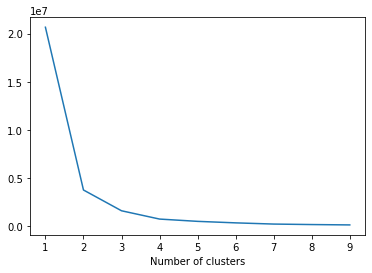

In [0]:
sse={}
df_recency = df_product[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [0]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_product[['Recency']])
df_product['RecencyCluster'] = kmeans.predict(df_product[['Recency']])

In [0]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [0]:
df_product = order_cluster('RecencyCluster', 'Recency',df_product,False)

In [0]:
df_product.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,208.0,269.889423,27.563756,218.0,245.0,283.0,295.0,303.0
1,316.0,164.585443,23.772246,122.0,145.0,164.0,184.0,217.0
2,386.0,77.961140,22.710282,42.0,59.0,74.0,94.0,121.0
3,2854.0,5.116678,8.524642,0.0,0.0,1.0,7.0,40.0


Calculating purchase frequency + clustering

In [0]:
df_frequency = df_first.groupby('StockCode').InvoiceDate.count().reset_index()

In [0]:
df_frequency.columns = ['StockCode','Frequency']

In [0]:
df_frequency.head()

,StockCode,Frequency
0,10002,72
1,10080,14
2,10120,19
3,10123C,3
4,10124A,4


In [0]:
df_product = pd.merge(df_product, df_frequency, on='StockCode')

In [0]:
df_product.head()

,StockCode,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,85123A,1.0,0,3,1778
1,71053,3.0,1,3,279
2,84406B,4.0,0,3,249
3,84029G,1.0,0,3,302
4,84029E,1.0,0,3,233


In [0]:
df_product.Frequency.describe()

count    3764.000000
mean       96.507439
std       146.917760
min         1.000000
25%        12.000000
50%        45.000000
75%       118.250000
max      1778.000000
Name: Frequency, dtype: float64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

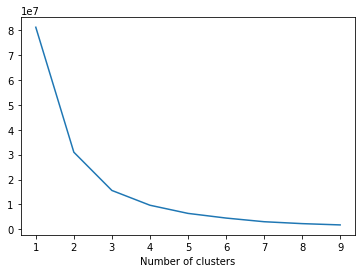

In [0]:
sse={}
df_frequency = df_product[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_frequency)
    df_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [0]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(df_product[['Frequency']])
df_product['FrequencyCluster'] = kmeans.predict(df_product[['Frequency']])

In [0]:
df_product.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,921.0,91.786102,24.402042,56.0,70.00,88.0,111.00,141.0
1,87.0,556.356322,75.867384,448.0,486.50,547.0,608.50,704.0
2,2075.0,19.013494,15.927506,1.0,5.00,15.0,30.00,55.0
3,218.0,332.100917,49.103661,262.0,291.00,323.0,370.00,443.0
4,34.0,881.617647,99.198001,729.0,812.75,868.5,946.75,1080.0
5,5.0,1546.600000,186.547045,1270.0,1490.00,1578.0,1617.00,1778.0
6,424.0,190.464623,33.494909,142.0,163.00,182.0,216.25,261.0


In [0]:
df_product = order_cluster('FrequencyCluster', 'Frequency',df_product,True)

Calculating orders value ($) + clustering

In [0]:
df_first['Revenue'] = df_first['UnitPrice'] * df_first['Quantity']

In [0]:
df_first['UnitPrice'].describe()


count    363254.000000
mean          3.980509
std          38.293008
min           0.000000
25%           1.250000
50%           2.100000
75%           4.130000
max       13541.330000
Name: UnitPrice, dtype: float64

In [0]:
df_revenue = df_first.groupby('StockCode').Revenue.sum().reset_index()

In [0]:
df_revenue.head()

,StockCode,Revenue
0,10002,759.89
1,10080,81.26
2,10120,26.88
3,10123C,3.25
4,10124A,5.04


In [0]:
df_product = pd.merge(df_product, df_revenue, on='StockCode')

In [0]:
df_product.Revenue.describe()

count      3764.000000
mean       1956.274239
std        5643.542857
min           0.000000
25%          97.082500
50%         490.455000
75%        1565.895000
max      141397.050000
Name: Revenue, dtype: float64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

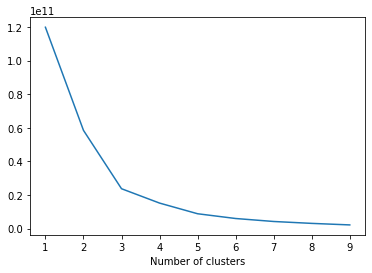

In [0]:
sse={}
df_revenue = df_product[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [0]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_product[['Revenue']])
df_product['RevenueCluster'] = kmeans.predict(df_product[['Revenue']])

In [0]:
df_product = order_cluster('RevenueCluster', 'Revenue',df_product,True)

In [0]:
df_product.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3077.0,527.740086,590.003490,0.00,66.0900,296.800,783.150,2418.60
1,483.0,4335.071760,1408.125471,2444.18,3153.1800,4009.480,5413.800,7758.39
2,129.0,11308.418372,2364.006216,7831.27,9422.9000,11002.130,13015.220,16204.85
3,66.0,21650.985152,5180.341062,16579.50,18104.2275,20052.935,23081.835,43804.77
4,7.0,69293.820000,15804.962009,51426.62,54884.3650,69985.970,81873.405,90128.61
5,2.0,136456.300000,6987.275658,131515.55,133985.9250,136456.300,138926.675,141397.05



Segmentation - general

In [0]:
df_product.head()

,StockCode,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,85123A,1.0,0,3,1778,6,83393.74,4
1,85099B,1.0,0,3,1617,6,69985.97,4
2,47566,1.0,0,3,1490,6,90128.61,4
3,M,3.0,0,3,225,2,52811.08,4
4,23166,4.0,2,3,164,2,80353.07,4


In [0]:
df_product['OverallScore'] = df_product['RecencyCluster'] + df_product['FrequencyCluster'] + df_product['RevenueCluster']

In [0]:
df_product.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,270.665025,4.413793,76.062315
1,167.226481,11.843206,159.878815
2,83.645503,17.804233,208.657778
3,10.948841,26.164668,341.440875
4,4.119745,89.603822,1104.844510
5,2.832143,156.946429,2244.580214
6,2.000000,203.640000,4154.880933
7,0.432927,313.256098,5647.006463
8,0.268657,376.164179,9852.701194


In [0]:
df_product.groupby('OverallScore')['Recency'].count()

OverallScore
0      203
1      287
2      378
3     1251
4      785
5      280
6      225
7      164
8       67
9       56
10      36
11      25
12       3
13       3
14       1
Name: Recency, dtype: int64

In [0]:
df_product['Segment'] = 'Low-Value'
df_product.loc[df_product['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_product.loc[df_product['OverallScore']>4,'Segment'] = 'High-Value' 

In [0]:
df_product.head()

,StockCode,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,85123A,1.0,0,3,1778,6,83393.74,4,13,High-Value
1,85099B,1.0,0,3,1617,6,69985.97,4,13,High-Value
2,47566,1.0,0,3,1490,6,90128.61,4,13,High-Value
3,M,3.0,0,3,225,2,52811.08,4,9,High-Value
4,23166,4.0,2,3,164,2,80353.07,4,9,High-Value


Features engineering (new features calculation)

In [0]:
df_first.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,5504.0,United Kingdom,15.30
1,1,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,5504.0,United Kingdom,20.34
2,1,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,5504.0,United Kingdom,22.00
3,1,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,5504.0,United Kingdom,20.34
4,1,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,5504.0,United Kingdom,20.34


In [0]:
#create a dataframe with CustomerID and Invoice Date
df_day_order = df_first[['StockCode','InvoiceDate']]

In [0]:
#Convert Invoice Datetime to day
df_day_order['InvoiceDay'] = df_first['InvoiceDate'].dt.date

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df_day_order = df_day_order.sort_values(['StockCode','InvoiceDate'])

In [0]:
#Drop duplicates
df_day_order = df_day_order.drop_duplicates(subset=['StockCode','InvoiceDay'],keep='first')

In [0]:
#shifting last 3 purchase dates
df_day_order['PrevInvoiceDate'] = df_day_order.groupby('StockCode')['InvoiceDay'].shift(1)
df_day_order['T2InvoiceDate'] = df_day_order.groupby('StockCode')['InvoiceDay'].shift(2)
df_day_order['T3InvoiceDate'] = df_day_order.groupby('StockCode')['InvoiceDay'].shift(3)

In [0]:
df_day_order.head()

,StockCode,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
31,10002,2010-12-01 08:45:00,2010-12-01,NaN,NaN,NaN
4238,10002,2010-12-02 14:23:00,2010-12-02,2010-12-01,NaN,NaN
5384,10002,2010-12-03 11:19:00,2010-12-03,2010-12-02,2010-12-01,NaN
7479,10002,2010-12-05 11:02:00,2010-12-05,2010-12-03,2010-12-02,2010-12-01
10038,10002,2010-12-06 08:42:00,2010-12-06,2010-12-05,2010-12-03,2010-12-02


In [0]:
df_day_order['DayDiff'] = (df_day_order['InvoiceDay'] - df_day_order['PrevInvoiceDate']).dt.days
df_day_order['DayDiff2'] = (df_day_order['InvoiceDay'] - df_day_order['T2InvoiceDate']).dt.days
df_day_order['DayDiff3'] = (df_day_order['InvoiceDay'] - df_day_order['T3InvoiceDate']).dt.days

In [0]:
df_day_order.head(10)

,StockCode,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
31,10002,2010-12-01 08:45:00,2010-12-01,NaN,NaN,NaN,NaN,NaN,NaN
4238,10002,2010-12-02 14:23:00,2010-12-02,2010-12-01,NaN,NaN,1.0,NaN,NaN
5384,10002,2010-12-03 11:19:00,2010-12-03,2010-12-02,2010-12-01,NaN,1.0,2.0,NaN
7479,10002,2010-12-05 11:02:00,2010-12-05,2010-12-03,2010-12-02,2010-12-01,2.0,3.0,4.0
10038,10002,2010-12-06 08:42:00,2010-12-06,2010-12-05,2010-12-03,2010-12-02,1.0,3.0,4.0
14827,10002,2010-12-07 15:28:00,2010-12-07,2010-12-06,2010-12-05,2010-12-03,1.0,2.0,4.0
17365,10002,2010-12-08 12:24:00,2010-12-08,2010-12-07,2010-12-06,2010-12-05,1.0,2.0,3.0
20279,10002,2010-12-09 14:08:00,2010-12-09,2010-12-08,2010-12-07,2010-12-06,1.0,2.0,3.0
22880,10002,2010-12-10 10:56:00,2010-12-10,2010-12-09,2010-12-08,2010-12-07,1.0,2.0,3.0
26301,10002,2010-12-13 09:35:00,2010-12-13,2010-12-10,2010-12-09,2010-12-08,3.0,4.0,5.0


In [0]:
df_day_diff = df_day_order.groupby('StockCode').agg({'DayDiff': ['mean','std']}).reset_index()



In [0]:
df_day_diff.columns = ['StockCode', 'DayDiffMean','DayDiffStd']

In [0]:
df_day_diff.head()

,StockCode,DayDiffMean,DayDiffStd
0,10002,3.000000,3.018462
1,10080,17.666667,31.022963
2,10120,19.933333,21.055935
3,10123C,59.000000,45.254834
4,10124A,37.000000,27.000000


In [0]:
df_day_order_last = df_day_order.drop_duplicates(subset=['StockCode'],keep='last')

In [0]:
df_day_order_last.head(10)

,StockCode,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
156683,10002,2011-04-18 12:56:00,2011-04-18,2011-04-15,2011-04-03,2011-04-01,3.0,15.0,17.0
354311,10080,2011-09-27 09:24:00,2011-09-27,2011-09-19,2011-09-08,2011-09-05,8.0,19.0,22.0
357647,10120,2011-09-28 15:18:00,2011-09-28,2011-09-27,2011-09-20,2011-09-04,1.0,8.0,24.0
137998,10123C,2011-03-31 13:14:00,2011-03-31,2011-03-04,2010-12-03,NaN,27.0,118.0,NaN
132356,10124A,2011-03-27 16:08:00,2011-03-27,2011-03-17,2011-02-08,2010-12-06,10.0,47.0,111.0
360421,10124G,2011-09-29 14:46:00,2011-09-29,2011-03-17,2010-12-02,NaN,196.0,301.0,NaN
362138,10125,2011-09-30 12:06:00,2011-09-30,2011-09-28,2011-09-05,2011-08-24,2.0,25.0,37.0
321758,10133,2011-09-07 10:07:00,2011-09-07,2011-09-05,2011-09-02,2011-09-01,2.0,5.0,6.0
357923,10135,2011-09-28 15:42:00,2011-09-28,2011-09-26,2011-09-22,2011-09-21,2.0,6.0,7.0
355145,11001,2011-09-27 12:52:00,2011-09-27,2011-09-22,2011-09-21,2011-09-19,5.0,6.0,8.0


In [0]:
df_day_order_last = df_day_order_last.dropna()

In [0]:
df_day_order_last = pd.merge(df_day_order_last, df_day_diff, on='StockCode')

In [0]:
df_product = pd.merge(df_product, df_day_order_last[['StockCode','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='StockCode')


In [0]:
df_product.head()

,StockCode,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,85123A,1.0,0,3,1778,6,83393.74,4,13,High-Value,1.0,2.0,3.0,1.241803,0.833293
1,85099B,1.0,0,3,1617,6,69985.97,4,13,High-Value,1.0,2.0,3.0,1.262500,0.859265
2,47566,1.0,0,3,1490,6,90128.61,4,13,High-Value,1.0,2.0,3.0,1.280851,0.927877
3,M,3.0,0,3,225,2,52811.08,4,9,High-Value,2.0,3.0,7.0,2.330769,1.930532
4,23166,4.0,2,3,164,2,80353.07,4,9,High-Value,1.0,2.0,3.0,3.162500,12.590376


Labels grouping - final model

In [0]:
df_class = df_product.copy()

In [0]:
df_class = pd.get_dummies(df_class)

In [0]:
df_class.tail(10)

,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,StockCode_10002,StockCode_10080,StockCode_10120,StockCode_10124A,StockCode_10125,StockCode_10133,StockCode_10135,StockCode_11001,StockCode_15030,StockCode_15034,StockCode_15036,StockCode_15039,StockCode_15044A,StockCode_15044B,StockCode_15044C,StockCode_15044D,StockCode_15056BL,StockCode_15056N,StockCode_15056P,StockCode_15056bl,StockCode_15056n,StockCode_15056p,StockCode_15058A,StockCode_15058B,StockCode_15058C,StockCode_15060B,StockCode_16008,...,StockCode_90211A,StockCode_90211B,StockCode_90212B,StockCode_90214A,StockCode_90214B,StockCode_90214C,StockCode_90214D,StockCode_90214E,StockCode_90214F,StockCode_90214G,StockCode_90214H,StockCode_90214I,StockCode_90214J,StockCode_90214K,StockCode_90214L,StockCode_90214M,StockCode_90214N,StockCode_90214P,StockCode_90214R,StockCode_90214S,StockCode_90214T,StockCode_90214V,StockCode_90214W,StockCode_90214Y,StockCode_90214Z,StockCode_BANK CHARGES,StockCode_C2,StockCode_DCGS0003,StockCode_DCGSSBOY,StockCode_DCGSSGIRL,StockCode_DOT,StockCode_M,StockCode_POST,StockCode_gift_0001_10,StockCode_gift_0001_20,StockCode_gift_0001_30,StockCode_gift_0001_50,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
3317,999.0,109,2,4,0,58.16,0,2,25.0,41.0,68.0,22.666667,5.859465,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3318,999.0,101,2,9,0,74.61,0,2,11.0,13.0,25.0,11.166667,5.036533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3319,999.0,113,2,9,0,132.72,0,2,15.0,29.0,35.0,10.200000,5.848077,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3320,999.0,66,2,10,0,150.00,0,2,1.0,2.0,15.0,10.750000,14.973787,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3321,95.0,59,2,6,0,124.78,0,2,1.0,19.0,77.0,18.000000,23.526581,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3322,999.0,56,2,4,0,47.70,0,2,4.0,53.0,89.0,29.666667,23.158872,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3323,999.0,72,2,10,0,38.31,0,2,2.0,7.0,8.0,6.222222,10.940496,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3324,137.0,93,2,14,0,78.78,0,2,5.0,6.0,8.0,2.444444,1.589899,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3325,999.0,66,2,10,0,38.00,0,2,2.0,5.0,8.0,2.750000,1.035098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3326,999.0,44,2,10,0,33.93,0,2,17.0,27.0,28.0,7.333333,5.955390,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [0]:
df_product.NextPurchaseDay.describe()

count    3327.000000
mean      157.804328
std       343.882005
min         1.000000
25%         3.000000
50%         8.000000
75%        40.000000
max       999.000000
Name: NextPurchaseDay, dtype: float64

In [0]:
df_class['NextPurchaseDayRange'] = 2
df_class.loc[df_class.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
df_class.loc[df_class.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0


In [0]:
df_class.NextPurchaseDayRange.value_counts()/len(df_product)

2    0.662158
0    0.226931
1    0.110911
Name: NextPurchaseDayRange, dtype: float64

In [0]:
df_class = df_class.drop('NextPurchaseDay',axis=1)

In [0]:
X, y = df_class.drop('NextPurchaseDayRange',axis=1), df_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [0]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))


In [0]:
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LR [0.8730278  0.87819549]
NB [0.70172802 0.70451128]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF [0.85123967 0.87368421]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC [0.82494365 0.82781955]
Dtree [0.85875282 0.87744361]
XGB [0.87528174 0.87744361]
KNN [0.82569497 0.83082707]


In [0]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))



Accuracy of XGB classifier on training set: 0.92
Accuracy of XGB classifier on test set: 0.87


In [0]:
y_pred = xgb_model.predict(X_test)

In [0]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       158
           1       0.61      0.42      0.50        86
           2       0.89      0.99      0.94       422

    accuracy                           0.87       666
   macro avg       0.81      0.74      0.77       666
weighted avg       0.86      0.87      0.86       666



In [0]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.8778682745951369)

In [0]:
xgb_model = xgb.XGBClassifier(max_depth=3, min_child_weight=1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))



Accuracy of XGB classifier on training set: 0.92
Accuracy of XGB classifier on test set: 0.87


In [0]:
y_pred = xgb_model.predict(X_test)

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       158
           1       0.61      0.42      0.50        86
           2       0.89      0.99      0.94       422

    accuracy                           0.87       666
   macro avg       0.81      0.74      0.77       666
weighted avg       0.86      0.87      0.86       666

